# MCT4052 Workshop 3c: Artificial Neural Network Classifier

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train and use an ANN (within the scikit learn package) for classification purposes. The dataset, features extraction and classification problem are identical to the example in Workshop2c, but we replace the Gaussian naïve Bayesian classifier with a Multi Layer Perceptron (MLP, i.e. a Feed Forward fully-connected ANN). Also, the feature set has been slightly changed compared to Workshop2c.


When working with neural networks (for both regression and classification tasks) there are many hyper-parameters we can tune (architecture, activation function, learning rate, etc..).

To get a basic understanding of how these may impact the result, explore this **[demo](https://playground.tensorflow.org/)**.

In particular here we use the [MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) which is an ANN designed to solve classification tasks. We can customize everything except the actual output layer, which is designed to produce one (or more, but this is unusual) discrete or binary labels (e.g. integer numbers).

If you want to learn more about the softmax (activation function for MLP Classifier neurons in the output layer), you can read this [post](https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60).

In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use("seaborn-v0_8") 
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
#loading the metadata in a pandas data structure and displaying
metadata = pd.read_csv('./data/examples4/meta.csv')

In [3]:
#finding unique labels (i.e. how many different classes in the dataset)
classes = list(metadata.label.unique()) # finding unique elements in the 'label' column
print('There are',len(classes),'different classes:',classes)

There are 5 different classes: ['cello', 'guitar', 'clarinet', 'flute', 'harmonica']


In [4]:
sr = 22050

#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features are from librosa and are all scalar (we take the mean over multiple blocks computed across the duration, which differs for each file).
#The function returns a list containing the mean of the features given an filename, and the sampling rate at which we are resampling the file
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(filename, sr=sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = np.mean(librosa.feature.mfcc(y=signal, n_mfcc=20), axis=1)
    
    return output

print('number of files in database',len(metadata.index))
#creating an array of zeros of the proper size where we will store computed features and lables
features = np.zeros((len(metadata.index),20)) #we compute the average of 3 features in the above code
labels = np.zeros((len(metadata.index))) #we store the labels as integers

#iterating over the rows of metadata
for i, row in metadata.iterrows():
    #print('processing',row['filename'])
    features[i,:] = extract_features('./data/examples4/'+row['filename'], sr)
    labels[i] = (classes.index(row['label']))

print('Done!')

number of files in database 60
Done!


In [5]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

In [6]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=52)

In [7]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

### Creating, training and testing the Multi Layer Perceptron (MLP) classifier

Compared to other classifiers, here we can specify more options such as the architecture of the network, the activation function of the perceptrons, the maximum number of iterations/epochs, etc).

In [8]:
#Import the classifier
from sklearn.neural_network import MLPClassifier

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPClassifier(hidden_layer_sizes=(10,5), max_iter=2000, activation='relu', verbose=True)

#train the model
mlp.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(feat_test)

Iteration 1, loss = 1.88334894
Iteration 2, loss = 1.87193311
Iteration 3, loss = 1.86079483
Iteration 4, loss = 1.84975157
Iteration 5, loss = 1.83874223
Iteration 6, loss = 1.82781899
Iteration 7, loss = 1.81702224
Iteration 8, loss = 1.80644842
Iteration 9, loss = 1.79632521
Iteration 10, loss = 1.78638940
Iteration 11, loss = 1.77664740
Iteration 12, loss = 1.76693571
Iteration 13, loss = 1.75727750
Iteration 14, loss = 1.74792186
Iteration 15, loss = 1.73883784
Iteration 16, loss = 1.72998593
Iteration 17, loss = 1.72126640
Iteration 18, loss = 1.71282082
Iteration 19, loss = 1.70466111
Iteration 20, loss = 1.69678686
Iteration 21, loss = 1.68894978
Iteration 22, loss = 1.68129804
Iteration 23, loss = 1.67380372
Iteration 24, loss = 1.66638921
Iteration 25, loss = 1.65898240
Iteration 26, loss = 1.65200905
Iteration 27, loss = 1.64519195
Iteration 28, loss = 1.63867108
Iteration 29, loss = 1.63252620
Iteration 30, loss = 1.62646665
Iteration 31, loss = 1.62060071
Iteration 32, los

### 2. Displaying the loss curve over the training iterations and performance metrics

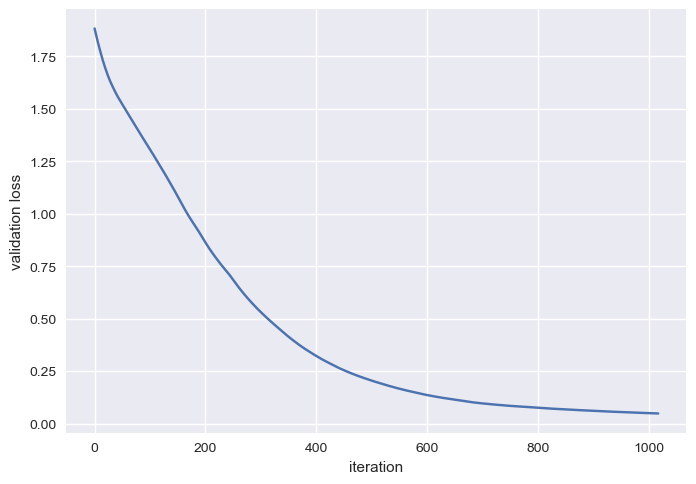

Number of mislabeled samples 4 out of 12
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.67      0.80         3
         2.0       1.00      0.33      0.50         3
         3.0       0.40      0.67      0.50         3
         4.0       1.00      1.00      1.00         1

    accuracy                           0.67        12
   macro avg       0.81      0.73      0.72        12
weighted avg       0.79      0.67      0.67        12

confusion matrix
[[2 0 0 0 0]
 [0 2 0 1 0]
 [0 0 1 2 0]
 [1 0 0 2 0]
 [0 0 0 0 1]]


In [9]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('validation loss')
plt.show()

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(lab_test,lab_predict))

In [10]:
print(mlp.coefs_[0].shape)
print(mlp.coefs_[1].shape)
print(mlp.coefs_[2].shape)
print(mlp.out_activation_)


(20, 10)
(10, 5)
(5, 5)
softmax


In [11]:
#displaying names of misclassified files
results = lab_test == lab_predict

for index, value in results.items():
    if value == False:
        print(metadata['filename'][index],classes[int(lab_test[index])])

70a2e253.wav clarinet
3071420d.wav guitar
b272072e.wav flute
5de123c3.wav clarinet


### Follow-up activities

1. Train again the ANN with the same settings, and observe if/how performances changes. If yes, understand why this is happening.

2. Analyze in details the results displayed above and reconcile these with the classification task and dataset. Look at the accuracy, what gets missclassifies, inspect the trainig process (verbose mode is ON), and the displayed messages. Also, compute the the selected performance metric on the training set and compare with the result on the tests set (assess wheter overfitting or unferfitting may happen).

3. Modify the network to improve the accuracy. You can explore increasing/decreasing the number of layers, the number of neuron per layer, the maximum number of training iterations, the activation function of the neurons (try logistic or tanh), and any other option you think may be relevant (refer to the documentation of MLPClassifier).

4. Try to change the regularization (called alpha) and learning rate (refer to the [MLP Classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)).

5. Try to work with less features, and use the [Percentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) to decide which to keep out of the 20 MFCC averaged over the entire file duration.

6. Repeat the above explorations with your own dataset and compare the performances with other classifiers included in Workshop 3.

7. Try another classifier on your dataaet, use a classifier included in [scikitlearn](https://scikit-learn.org/stable/supervised_learning.html) but not covered in the workshops and compare the performances with other classifiers included in Workshop 3 (consider making a table as final summary of everything you have tested vs performances).